In [ ]:
# https://www.kaggle.com/code/arnablaha05/emnist-letter-recognition
# dataset: https://www.kaggle.com/datasets/crawford/emnist/data?select=emnist-letters-train.csv

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
from PIL import Image
import shap

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.regularizers import l2

/Users/ruti/Desktop/Ruthie Thesis/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
testing_letter = pd.read_csv('emnist-letters-test.csv')
training_letter = pd.read_csv('emnist-letters-train.csv')
print(training_letter.shape)
print(testing_letter.shape)

(88799, 785)
(14799, 785)


In [3]:
#training_letters
y1 = np.array(training_letter.iloc[:,0].values)
x1 = np.array(training_letter.iloc[:,1:].values)
#testing_labels
y2 = np.array(testing_letter.iloc[:,0].values)
x2 = np.array(testing_letter.iloc[:,1:].values)
print(y1.shape)
print(x1.shape)

(88799,)
(88799, 784)


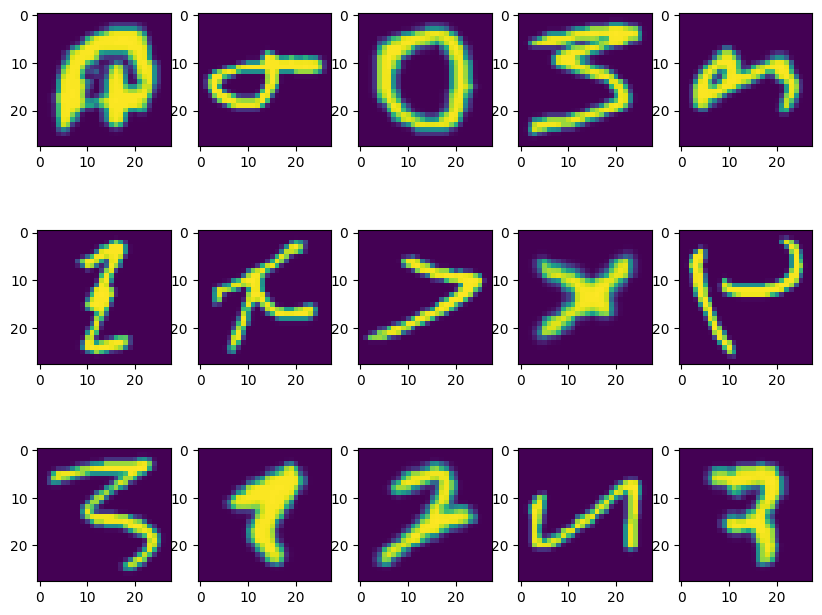

In [4]:
import matplotlib.pyplot as plt 
fig,axes = plt.subplots(3,5,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(x1[i].reshape([28,28]))

In [5]:
# Normalise and reshape data
train_images = x1 / 255.0
test_images = x2 / 255.0

train_images_number = train_images.shape[0]
train_images_height = 28
train_images_width = 28
train_images_size = train_images_height*train_images_width

train_images = train_images.reshape(train_images_number, train_images_height, train_images_width, 1)

test_images_number = test_images.shape[0]
test_images_height = 28
test_images_width = 28
test_images_size = test_images_height*test_images_width

test_images = test_images.reshape(test_images_number, test_images_height, test_images_width, 1)
# Transform labels
number_of_classes = 37

y1 = tf.keras.utils.to_categorical(y1, number_of_classes)
y2 = tf.keras.utils.to_categorical(y2, number_of_classes)

In [6]:
train_x,test_x,train_y,test_y = train_test_split(train_images,y1,test_size=0.2,random_state = 42)

In [7]:
# Define the number of classes (adjust based on your EMNIST dataset subset)
number_of_classes = 37  # Update this based on your specific EMNIST subset (e.g., Balanced, Letters, Digits)

In [28]:
# Build the model
model = Sequential()

# First convolutional layer with BatchNormalization and LeakyReLU
model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Fully connected layers with BatchNormalization, LeakyReLU, and Dropout
model.add(Dense(512, kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))

model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(number_of_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
model.summary()

/Users/ruti/Desktop/Ruthie Thesis/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ruti/Desktop/Ruthie Thesis/venv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 232,613 (908.64 KB)

 Trainable params: 230,885 (901.89 KB)

 Non-trainable params: 1,728 (6.75 KB)

In [29]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [31]:
history = model.fit(train_x,train_y,epochs=30,validation_data=(test_x,test_y))

Epoch 1/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 68s 30ms/step - accuracy: 0.7656 - loss: 1.4730 - val_accuracy: 0.7943 - val_loss: 1.2717
Epoch 2/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 66s 30ms/step - accuracy: 0.7873 - loss: 1.2705 - val_accuracy: 0.8005 - val_loss: 1.1629
Epoch 3/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 64s 29ms/step - accuracy: 0.8027 - loss: 1.1711 - val_accuracy: 0.7985 - val_loss: 1.1713
Epoch 4/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 63s 28ms/step - accuracy: 0.8055 - loss: 1.1157 - val_accuracy: 0.8445 - val_loss: 0.9824
Epoch 5/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 63s 28ms/step - accuracy: 0.8118 - loss: 1.0784 - val_accuracy: 0.8242 - val_loss: 1.0201
Epoch 6/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 63s 28ms/step - accuracy: 0.8135 - loss: 1.0590 - val_accuracy: 0.8502 - val_loss: 0.9120
Epoch 7/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 62s 28ms/step - accuracy: 0.8161 - loss: 1.0551 - val_accuracy: 0.7972 - val_loss: 1.1100
Epoch 8/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 63s 28ms/step - accuracy: 0.8149 -

In [33]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_x, test_y)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8341 - loss: 0.9381
Test Accuracy: 83.23%


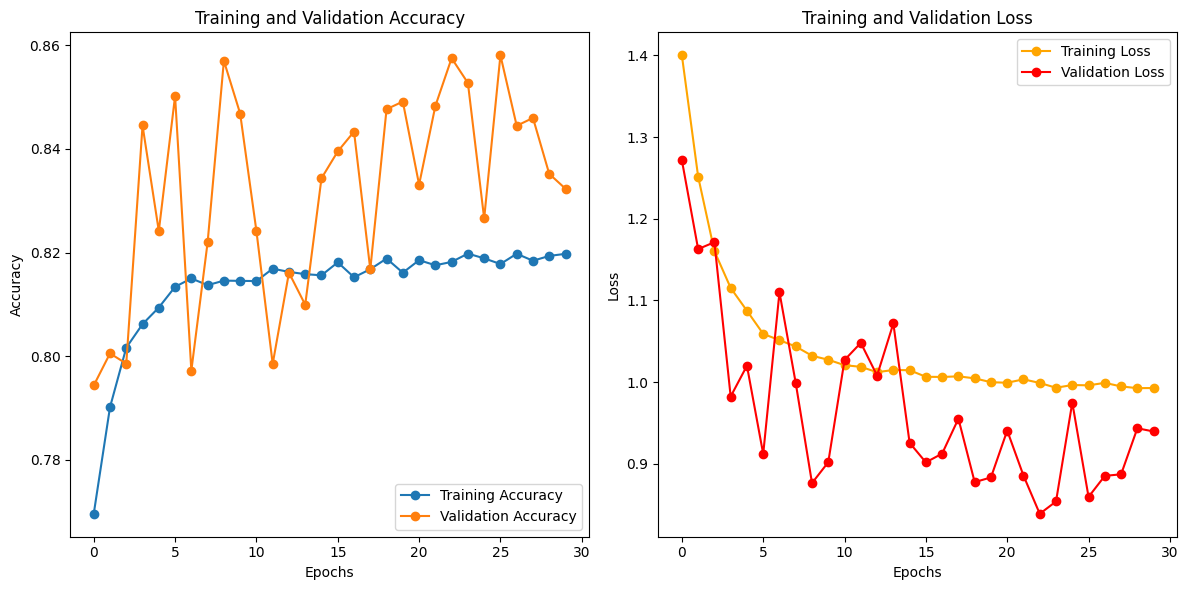

In [34]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [35]:
# Save the trained model to a file
model.save('trained_models/emnist_model.keras')

In [8]:
# For future use, read the trained model from a file
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('trained_models/emnist_model.keras')

2025-03-13 21:23:58.237643: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-03-13 21:23:58.237705: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-13 21:23:58.237708: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-13 21:23:58.238012: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-13 21:23:58.238059: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Categorize images by prediction - test images

In [22]:
def save_images_by_prediction(img_data, true_labels, pred_labels, save_directory="categorized_images"):
    """
    Categorize and save images based on their predicted and true labels.

    Parameters:
    - img_data: The dataset containing the images.
    - true_labels: The ground-truth labels for the images (one-hot or integer-encoded).
    - pred_labels: The predicted labels for the images (integer-encoded).
    - save_directory: The base directory to save the categorized images.
    """
    import numpy as np
    import os
    import matplotlib.pyplot as plt

    # Ensure the save directory exists
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # Process each image in the dataset
    for idx, (img, true_label, pred_label) in enumerate(zip(img_data, true_labels, pred_labels)):
        # Convert one-hot encoded true labels to scalar values if necessary
        if isinstance(true_label, np.ndarray) or len(np.shape(true_label)) > 0:
            true_label = np.argmax(true_label)

        # Determine the folder based on prediction correctness
        if true_label == pred_label:
            folder = os.path.join(save_directory, f"digit_{true_label}")
        else:
            folder = os.path.join(save_directory, "errors")

        # Create the folder if it doesn't exist
        os.makedirs(folder, exist_ok=True)

        # Reshape the image if necessary
        if img.ndim == 1:
            img = img.reshape((28, 28))
        elif img.ndim == 3 and img.shape[-1] == 1:
            img = img.reshape((28, 28))
        elif img.ndim == 3 and img.shape[-1] == 3:
            img = img.reshape((28, 28, 3))

        # Save the image
        save_path = os.path.join(folder, f"img_{idx}_pred_{pred_label}_true_{true_label}.png")
        plt.imsave(save_path, img, cmap='gray' if img.ndim == 2 else None)

    print(f"Images have been categorized and saved in: {save_directory}")


In [37]:
y_test_pred = model.predict(test_x)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Example usage with test data
save_images_by_prediction(
    img_data=test_x,                # Test dataset
    true_labels=test_y,             # True labels (one-hot or scalar)
    pred_labels=y_test_pred_classes, # Predicted labels
    save_directory="EMNIST_test_images" # Directory to save images
)

555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Images have been categorized and saved in: EMNIST_test_images


# Categorize images by prediction - train images

In [9]:
def save_train_images(img_data, true_labels, save_directory="EMNIST_train_images"):
    """
    Categorize and save EMNIST train images into folders based on their class index.

    Parameters:
    - img_data: The dataset containing the images.
    - true_labels: The ground-truth labels for the images (one-hot or integer-encoded).
    - save_directory: The base directory to save the categorized images.
    """
    # ✅ Ensure the save directory exists
    os.makedirs(save_directory, exist_ok=True)

    # ✅ Process each image
    for idx, (img, true_label) in enumerate(zip(img_data, true_labels)):
        # Convert one-hot encoded true labels to scalar values if necessary
        if isinstance(true_label, np.ndarray) or len(np.shape(true_label)) > 0:
            true_label = np.argmax(true_label)

        # ✅ Define class folder
        folder = os.path.join(save_directory, f"class_{true_label}")  # Number-based class folder

        # ✅ Create the folder if it doesn't exist
        os.makedirs(folder, exist_ok=True)

        # ✅ Reshape the image if necessary
        if img.ndim == 1:
            img = img.reshape((28, 28))
        elif img.ndim == 3 and img.shape[-1] == 1:
            img = img.reshape((28, 28))

        # ✅ Save the image
        save_path = os.path.join(folder, f"img_{idx}_true_{true_label}.png")
        plt.imsave(save_path, img, cmap='gray')

    print(f"✅ All training images have been categorized and saved in: {save_directory}")


In [11]:
save_train_images(
    img_data=train_x,                
    true_labels=train_y,             
    save_directory="EMNIST_train_images"
)

✅ All training images have been categorized and saved in: EMNIST_train_images


# XAI

## SHAP

In [10]:
def generate_shap_explanations_from_folder(folder_path, model, output_labels=None):
    """
    Generates and saves SHAP explanations for all images in a folder.

    Parameters:
    - folder_path: Path to the folder containing images.
    - model: The trained model for classification.
    - output_labels: List of class labels (default: A-Z for EMNIST Letters).
    """
    # ✅ Ensure output labels are provided
    if output_labels is None:
        num_classes = 26  # EMNIST Letters (A-Z)
        output_labels = [chr(65 + i) for i in range(num_classes)]  # Labels 'A' to 'Z'
    
    # ✅ Create a SHAP explanations folder
    shap_folder = os.path.join(folder_path, "shap")
    os.makedirs(shap_folder, exist_ok=True)

    # ✅ Define model prediction function
    def f(x):
        return model.predict(x)  # Ensure output shape (num_samples, 26)

    # ✅ Select background samples from the training set
    background = train_x[np.random.choice(train_x.shape[0], 100, replace=False)]

    # ✅ Use SHAP Masking: Inpaint missing pixels with 'telea'
    masker = shap.maskers.Image("inpaint_telea", (28, 28, 1))

    # ✅ Initialize SHAP Explainer
    explainer = shap.Explainer(f, masker, output_names=output_labels)

    # ✅ Process each image in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".png") or file_name.endswith(".jpg"):
            image_path = os.path.join(folder_path, file_name)

            # ✅ Load image and preprocess
            image = Image.open(image_path).convert("L")  # Convert to grayscale
            image = image.resize((28, 28), Image.Resampling.LANCZOS)  # Resize
            image = np.array(image) / 255.0  # Normalize
            image = image.reshape((1, 28, 28, 1))  # Reshape for model

            # ✅ Compute SHAP values
            shap_values = explainer(image, max_evals=100, batch_size=50, outputs=list(range(len(output_labels))))

            # ✅ Extract SHAP values
            shap_values_list = shap_values.values  # Already shaped correctly

            # ✅ Create and save SHAP explanation plot
            fig, ax = plt.subplots(figsize=(6, 6))
            shap.image_plot(shap_values_list, -image, show=False)
            save_path = os.path.join(shap_folder, f"shap_{file_name}")
            plt.savefig(save_path, bbox_inches='tight')
            plt.close(fig)

            print(f"SHAP explanation saved: {save_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


2025-02-03 11:49:06.426133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
SHAP explanation saved: experiment_images/prediction_task/emnist/9_errors/shap/shap_img_804_pred_6_true_20.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
SHAP explanation saved: experiment_images/prediction_task/emnist/9_errors/shap/shap_img_109_pred_22_true_18.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
SHAP explanation

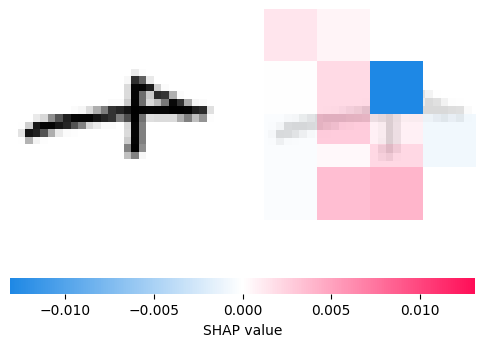

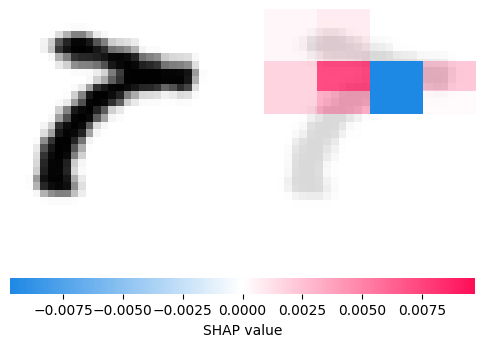

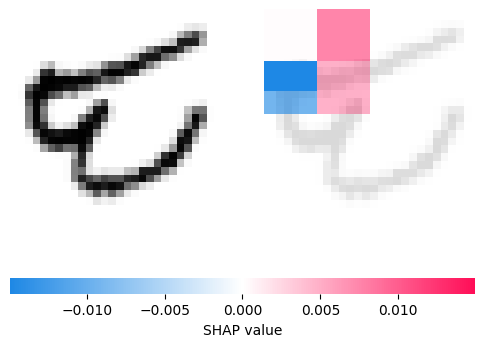

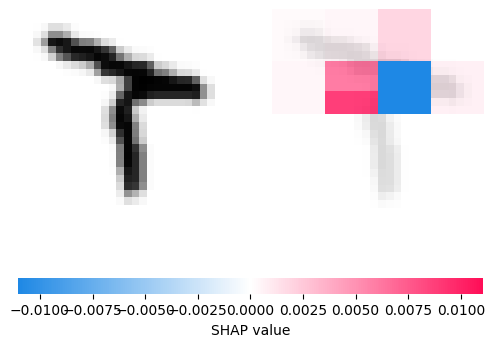

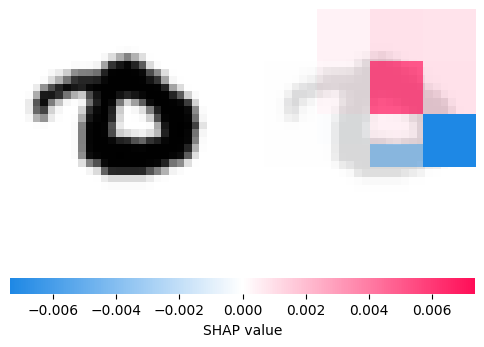

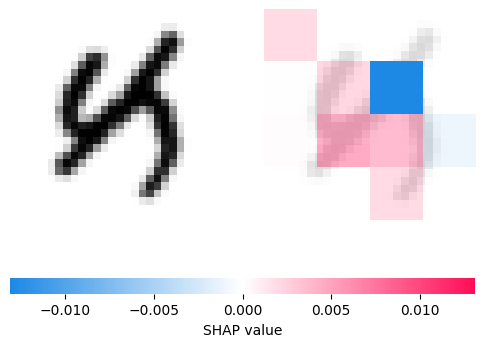

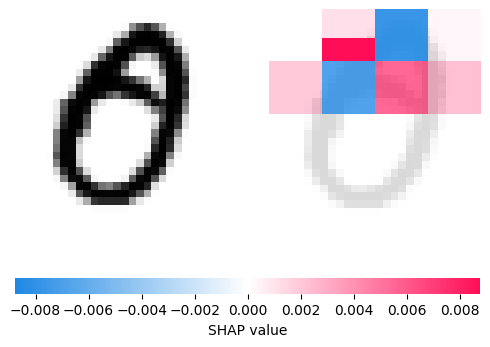

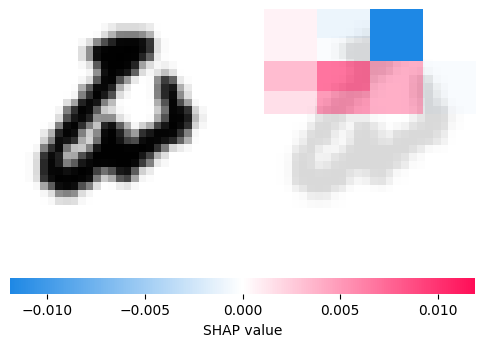

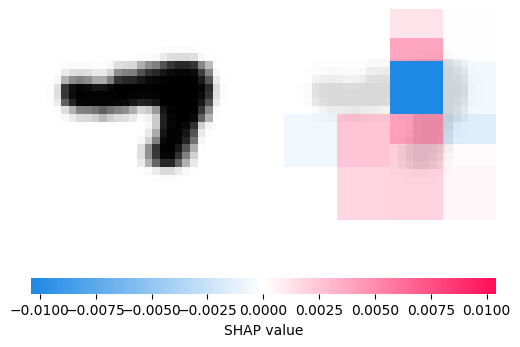

In [13]:
folder_path = "experiment_images/prediction_task/emnist"
generate_shap_explanations_from_folder(f"{folder_path}/9_errors", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
SHAP explanation saved: experiment_images/prediction_task/emnist/12_correct/shap/shap_img_7306_pred_25_true_25.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
SHAP explanation saved: experiment_images/prediction_task/emnist/12_correct/shap/shap_img_15247_pred_6_true_6.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━

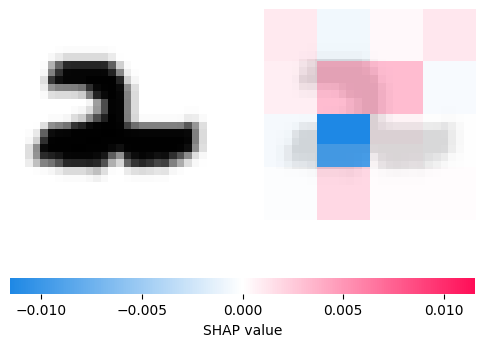

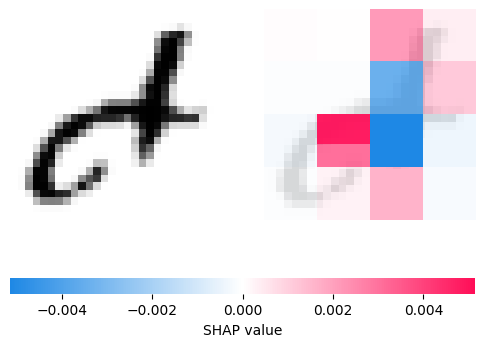

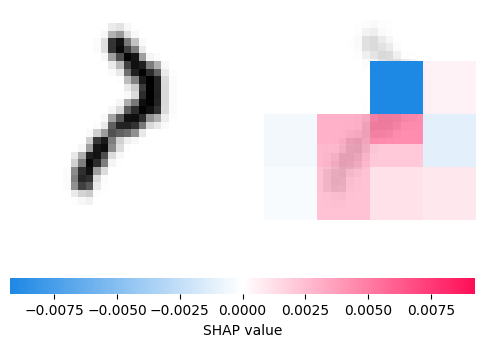

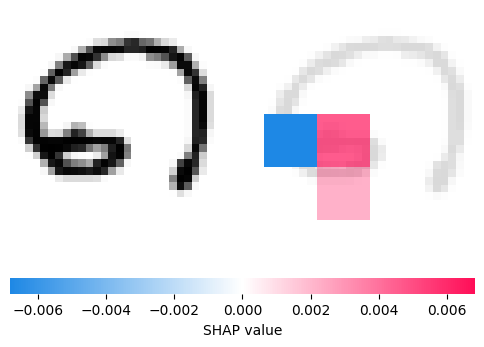

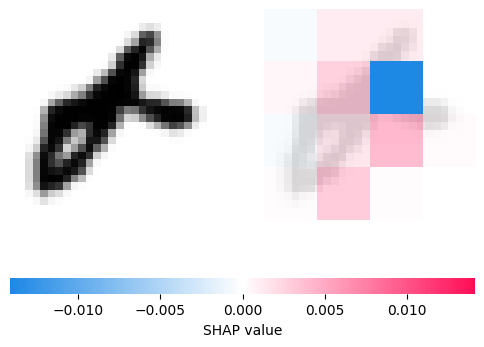

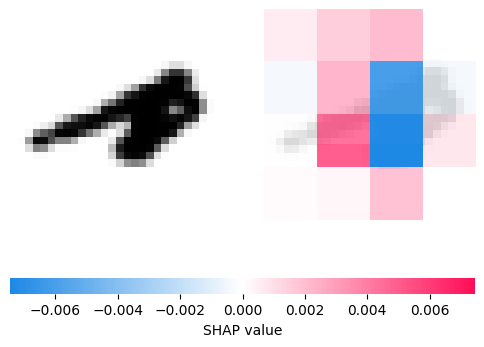

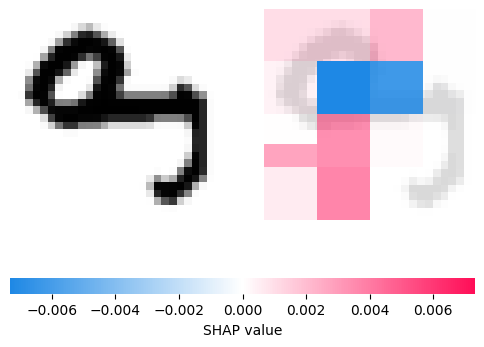

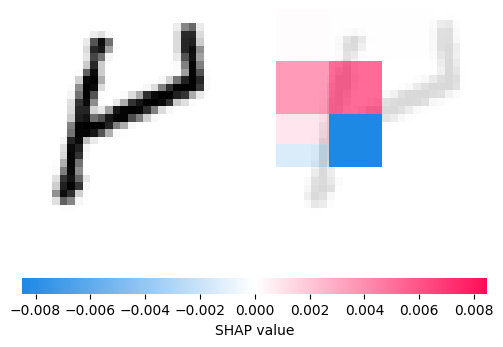

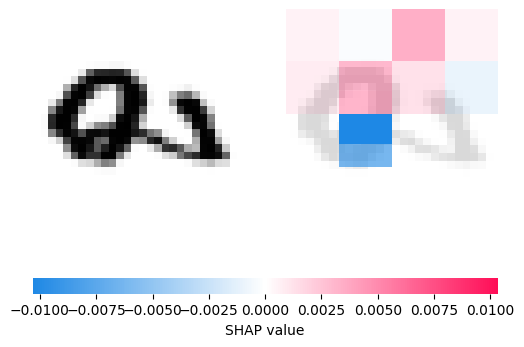

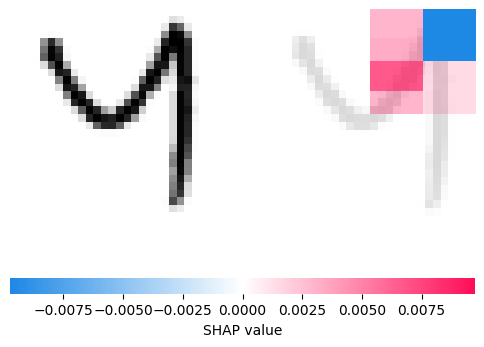

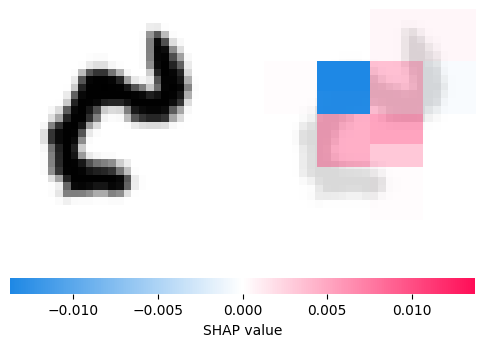

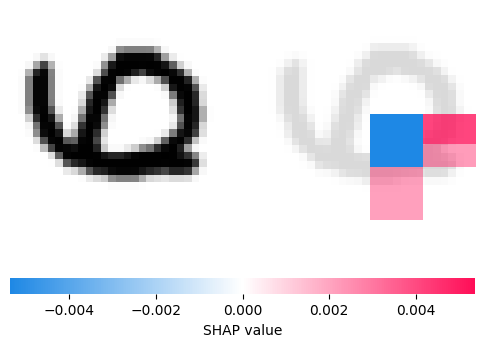

In [14]:
generate_shap_explanations_from_folder(f"{folder_path}/12_correct", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
SHAP explanation saved: experiment_testing/emnist/9_errors/shap/shap_img_17595_pred_2_true_26.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
SHAP explanation saved: experiment_testing/emnist/9_errors/shap/shap_img_17330_pred_9_true_20.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
SHAP e

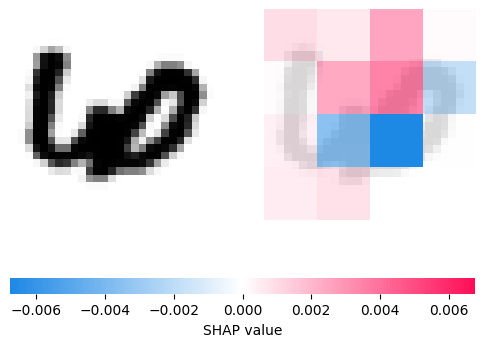

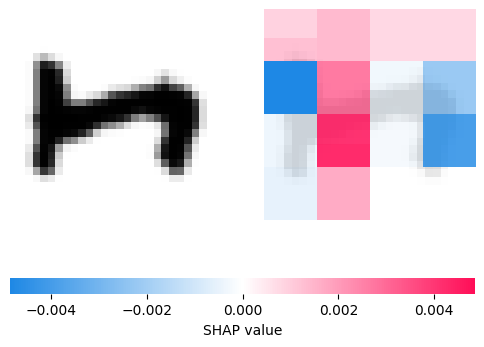

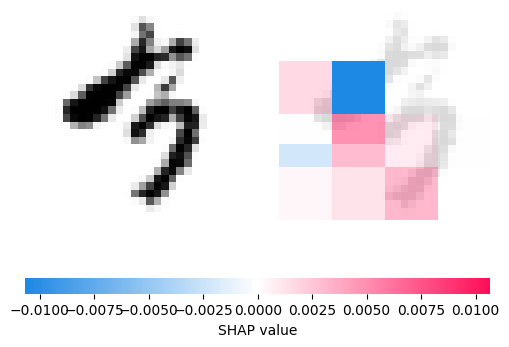

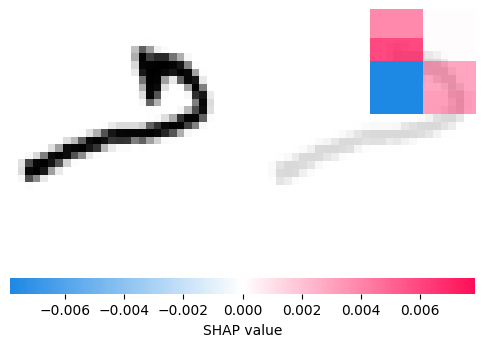

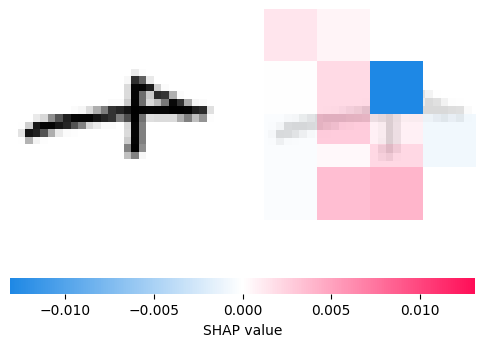

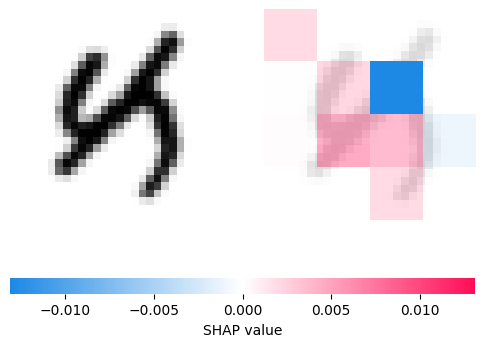

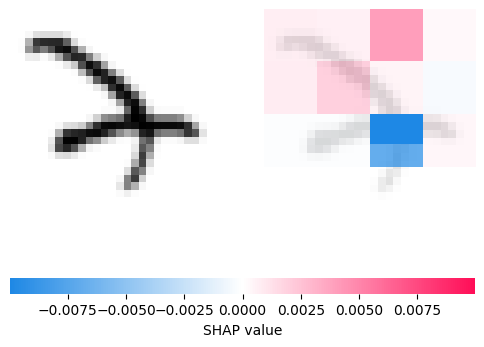

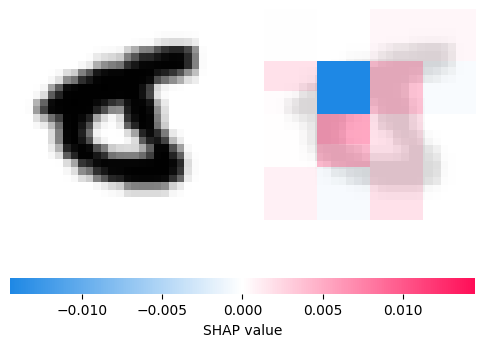

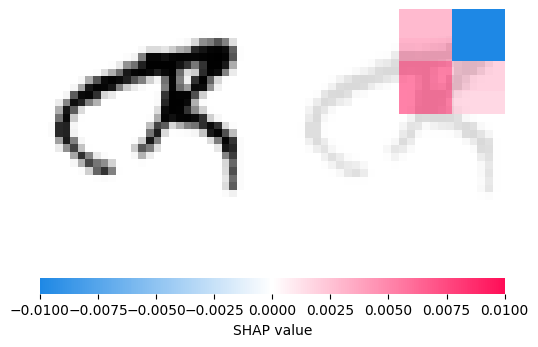

In [13]:
generate_shap_explanations_from_folder(f"experiment_testing/emnist/9_errors", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


2025-02-05 21:44:07.306629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
SHAP explanation saved: test/emnist/letters/shap/shap_img_3486_pred_16_true_16.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
SHAP explanation saved: test/emnist/letters/shap/shap_img_15523_pred_21_true_21.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
SHAP explanation saved: test/emnist/letters/shap/shap_img_4266_pred_17_t

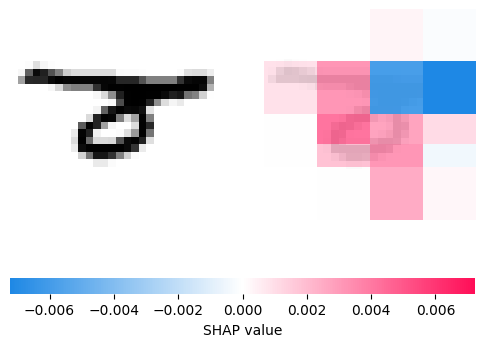

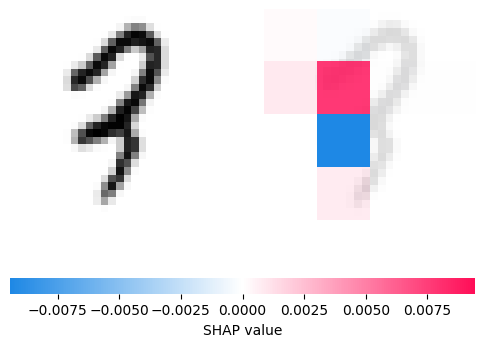

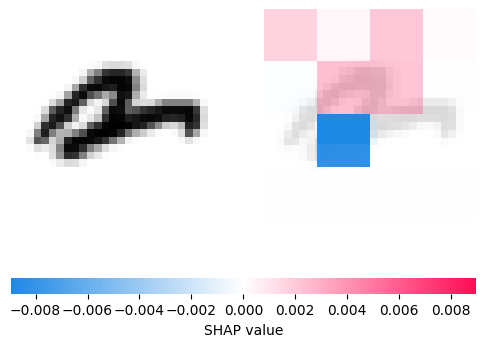

In [10]:
generate_shap_explanations_from_folder(f"test/emnist/letters", model)

2025-02-19 12:48:47.069021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
SHAP explanation saved: test/shap/shap_img_7595_pred_2_true_2.png


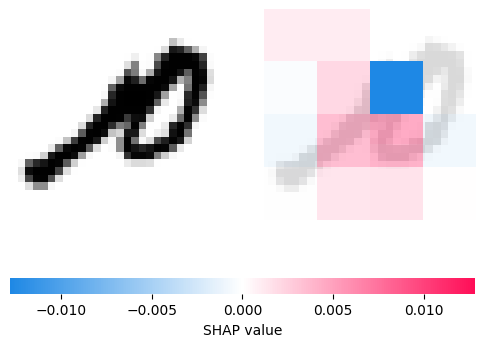

In [11]:
generate_shap_explanations_from_folder(f"test", model)

In [13]:
# import numpy as np
# import os
# import matplotlib.pyplot as plt

# def generate_shap_explanations_from_folder(folder_name, model, input_size):
#     """
#     Generate SHAP explanations for all images in a folder and save them in a subfolder.

#     Parameters:
#     - folder_name: The folder containing images with filenames formatted as
#       "img_{idx}_pred_{pred_label}_true_{true_label}.png".
#     - model: The trained CNN model used for generating SHAP explanations.
#     - input_size: Tuple specifying the input size expected by the model (e.g., (28, 28)).
#     """
#     # Create a SHAP subfolder inside the given folder
#     shap_folder = os.path.join(folder_name, "shap")
#     os.makedirs(shap_folder, exist_ok=True)

#     # Iterate over all image files in the folder
#     for file_name in os.listdir(folder_name):
#         if file_name.endswith(".png") and "pred_" in file_name and "true_" in file_name:
#             try:
#                 # Extract prediction and true label from the filename
#                 pred_label = int(file_name.split("pred_")[1].split("_")[0])
#                 true_label = int(file_name.split("true_")[1].split(".")[0])
#             except Exception as e:
#                 print(f"Error parsing filename '{file_name}': {e}")
#                 continue

#             # Load and preprocess the image
#             image_path = os.path.join(folder_name, file_name)
#             image = Image.open(image_path).convert("L")  # Convert to grayscale
#             image = image.resize(input_size, Image.Resampling.LANCZOS)  # Resize to model's input size
#             image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
#             image = image.reshape(input_size[0], input_size[1], 1)  # Ensure correct shape
#             image_input = np.expand_dims(image, axis=0)  # Add batch dimension

#             # Create a SHAP masker and explainer
#             masker = shap.maskers.Image("blur(256,256)", shape=(input_size[0], input_size[1], 1))  # Specify shape
#             explainer = shap.Explainer(model, masker)

#             # Compute SHAP values
#             shap_values = explainer(image_input)
#             shap_image = shap_values.values[..., pred_label].squeeze()

#             # Plot the SHAP explanation
#             fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#             im = ax.imshow(shap_image, cmap='coolwarm')
#             ax.axis('off')
#             ax.set_title(f"SHAP Explanation for Predicted Class {pred_label}")
#             cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#             cbar.set_label("SHAP Value", rotation=270, labelpad=15)

#             # Save the SHAP explanation image
#             save_path = os.path.join(shap_folder, f"shap_{file_name}")
#             fig.savefig(save_path, bbox_inches='tight')
#             plt.close(fig)  # Close the figure to save memory
#             print(f"SHAP explanation saved at: {save_path}")

In [16]:
# Example usage
path = "experiment_images/prediction_task/emnist"
input_size = (28, 28)  # Model's expected input size
generate_shap_explanations_from_folder(f"{path}/9_errors", model, input_size)

generate_shap_explanations_from_folder(f"{path}/12_correct", model, input_size)

SHAP explanation saved at: experiment_images/prediction_task/emnist/9_errors/shap/shap_img_804_pred_6_true_20.png
SHAP explanation saved at: experiment_images/prediction_task/emnist/9_errors/shap/shap_img_109_pred_22_true_18.png
SHAP explanation saved at: experiment_images/prediction_task/emnist/9_errors/shap/shap_img_1921_pred_13_true_2.png
SHAP explanation saved at: experiment_images/prediction_task/emnist/9_errors/shap/shap_img_549_pred_8_true_18.png
SHAP explanation saved at: experiment_images/prediction_task/emnist/9_errors/shap/shap_img_114_pred_7_true_2.png
SHAP explanation saved at: experiment_images/prediction_task/emnist/9_errors/shap/shap_img_1750_pred_26_true_24.png
SHAP explanation saved at: experiment_images/prediction_task/emnist/9_errors/shap/shap_img_1559_pred_17_true_15.png
SHAP explanation saved at: experiment_images/prediction_task/emnist/9_errors/shap/shap_img_208_pred_1_true_2.png
SHAP explanation saved at: experiment_images/prediction_task/emnist/9_errors/shap/sh

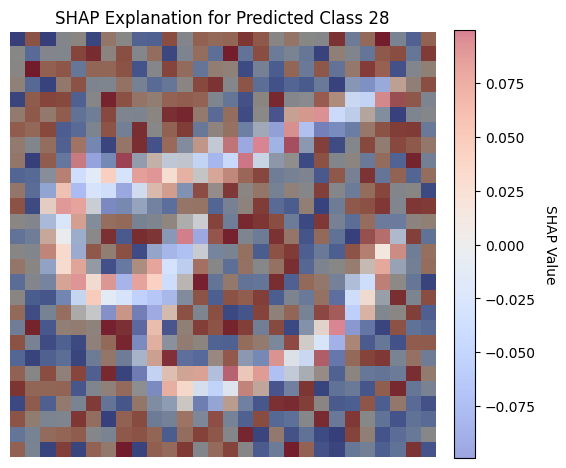

In [18]:
# def visualize_shap_overlay(image_path, shap_values, pred_label):
#     """
#     Overlay SHAP values on the original grayscale image.
    
#     Parameters:
#     - image_path: Path to the image.
#     - shap_values: SHAP values computed for the image.
#     - pred_label: The predicted class.
#     """

#     # Load original image
#     image = Image.open(image_path).convert("L")  # Convert to grayscale
#     image_array = np.array(image) / 255.0  # Normalize pixel values

#     # Create SHAP overlay
#     fig, ax = plt.subplots(figsize=(6, 6))
#     ax.imshow(image_array, cmap="gray", alpha=0.8)  # Show original image
#     shap_overlay = ax.imshow(shap_values, cmap="coolwarm", alpha=0.5)  # Overlay SHAP values
#     ax.axis("off")
#     ax.set_title(f"SHAP Explanation for Predicted Class {pred_label}")

#     # Add a colorbar
#     cbar = fig.colorbar(shap_overlay, ax=ax, fraction=0.046, pad=0.04)
#     cbar.set_label("SHAP Value", rotation=270, labelpad=15)

#     # Save or show the result
#     plt.show()

#     # fig.savefig(save_path, bbox_inches="tight")
#     # plt.close(fig)

# # Example usage (replace this with actual SHAP values from your model)
# image_path = "experiment_images/prediction_task/emnist/9_errors/img_1921_pred_13_true_2.png"
# shap_values = np.random.uniform(-0.1, 0.1, (28, 28))  # Placeholder SHAP values
# visualize_shap_overlay(image_path, shap_values, pred_label=28)

# Example based explanation

In [25]:
import os
import numpy as np
from PIL import Image, UnidentifiedImageError
from skimage.metrics import structural_similarity as ssim

def load_image(image_path):
    """Loads an image and converts it to grayscale numpy array."""
    try:
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        return np.array(image)
    except UnidentifiedImageError:
        print(f"Skipping non-image file: {image_path}")
        return None

def find_3nn_images(target_path, dataset_folder):
    """Finds the 3 nearest neighbors for a given image or all images in a folder."""
    if os.path.isdir(target_path):
        # If a folder is given, process all images inside it
        for img_name in os.listdir(target_path):
            img_path = os.path.join(target_path, img_name)
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                find_3nn_for_image(img_path, dataset_folder)
    else:
        # If a single image is given, process just that image
        find_3nn_for_image(target_path, dataset_folder)

def find_3nn_for_image(target_image_path, dataset_folder):
    """Finds the 3 nearest neighbors for a given image and saves them in a dedicated subfolder."""
    filename = os.path.basename(target_image_path)
    parts = filename.split('_')
    
    if len(parts) < 2:
        print(f"Skipping {filename}: filename format incorrect.")
        return
    
    img_id = parts[1]  # Extract image ID
    pred_label = parts[3]  # Extract predicted label
    
    # Define path to predicted class folder
    class_folder = os.path.join(dataset_folder, f"class_{pred_label}")
    if not os.path.exists(class_folder):
        print(f"Skipping {filename}: Class folder {class_folder} does not exist!")
        return
    
    # Load target image
    target_image = load_image(target_image_path)
    if target_image is None:
        return
    
    # Compute similarity scores for all images in class folder
    similarities = []
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        if img_path == target_image_path or not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue  # Skip the same image or non-image files
        
        img = load_image(img_path)
        if img is None:
            continue
        
        similarity = ssim(target_image, img)
        similarities.append((img_path, similarity))
    
    # Sort by similarity (descending order) and get top 3
    similarities.sort(key=lambda x: x[1], reverse=True)
    top_3 = [img[0] for img in similarities[:3]]
    
    # Create subfolder inside nearest_neighbors with only the image ID
    nn_base_folder = os.path.join(os.path.dirname(target_image_path), "nearest_neighbors")
    nn_subfolder = os.path.join(nn_base_folder, f"img_{img_id}")
    os.makedirs(nn_subfolder, exist_ok=True)
    
    # Copy top 3 images to the subfolder
    for img_path in top_3:
        img = Image.open(img_path)
        img.save(os.path.join(nn_subfolder, os.path.basename(img_path)))
    
    print(f"Processed {filename}: Nearest neighbors saved in {nn_subfolder}")
    return top_3

In [26]:
find_3nn_images("experiment_images/prediction_task/emnist/9_errors/letters/test/", "dataset_images/EMNIST_images/EMNIST_train_images/")

Processed img_17595_pred_2_true_26.png: Nearest neighbors saved in experiment_images/prediction_task/emnist/9_errors/letters/test/nearest_neighbors/img_17595
Processed img_17330_pred_9_true_20.png: Nearest neighbors saved in experiment_images/prediction_task/emnist/9_errors/letters/test/nearest_neighbors/img_17330
Processed img_15259_pred_23_true_8.png: Nearest neighbors saved in experiment_images/prediction_task/emnist/9_errors/letters/test/nearest_neighbors/img_15259
Processed img_17567_pred_4_true_10.png: Nearest neighbors saved in experiment_images/prediction_task/emnist/9_errors/letters/test/nearest_neighbors/img_17567
Processed img_804_pred_6_true_20.png: Nearest neighbors saved in experiment_images/prediction_task/emnist/9_errors/letters/test/nearest_neighbors/img_804
Processed img_1750_pred_26_true_24.png: Nearest neighbors saved in experiment_images/prediction_task/emnist/9_errors/letters/test/nearest_neighbors/img_1750
Processed img_13474_pred_24_true_20.png: Nearest neighbor

In [27]:
find_3nn_images("experiment_images/prediction_task/emnist/15_correct/letters/test/", "dataset_images/EMNIST_images/EMNIST_train_images/")

Processed img_5017_pred_8_true_8.png: Nearest neighbors saved in experiment_images/prediction_task/emnist/15_correct/letters/test/nearest_neighbors/img_5017
Processed img_3486_pred_16_true_16.png: Nearest neighbors saved in experiment_images/prediction_task/emnist/15_correct/letters/test/nearest_neighbors/img_3486
Processed img_17131_pred_4_true_4.png: Nearest neighbors saved in experiment_images/prediction_task/emnist/15_correct/letters/test/nearest_neighbors/img_17131
Processed img_8758_pred_18_true_18.png: Nearest neighbors saved in experiment_images/prediction_task/emnist/15_correct/letters/test/nearest_neighbors/img_8758
Processed img_12005_pred_17_true_17.png: Nearest neighbors saved in experiment_images/prediction_task/emnist/15_correct/letters/test/nearest_neighbors/img_12005
Processed img_4598_pred_11_true_11.png: Nearest neighbors saved in experiment_images/prediction_task/emnist/15_correct/letters/test/nearest_neighbors/img_4598
Processed img_15523_pred_21_true_21.png: Neare